# DiploDatos 2019 - Análisis de Series Temporales

## Integrantes

| Nombre | e-mail |
|------|------|
|Rivadero, Isabel | isarivadero@hotmail.com |
|Vargas, Miguel | lvc0107@protonmail.com |
|Mancuso, Fernando | manquius@gmail.com |



## Introducción
En este práctico se propone explorar un dataset que contiene información de varias agencias de correo de Brasil, con el objetivo de extraer toda la información relevante sobre estos datos y presentarla de manera organizada y sencilla.
En estos datos vamos a encontrar información geográfica de los compradores y vendedores, el tipo de servicio por el que viajan los paquetes, el estado del paquete, algunas fechas relevantes y la cantidad de días hábiles que tardó el envío en llegar a su destino (target).

## Dataset

## Definiciones

In [267]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
sb.set(rc={'figure.figsize':(10.5,8.5)})

cols = ['service',
        'sender_zipcode',
        'receiver_zipcode',
        'sender_state',
        'receiver_state',
        'shipment_type',
        'quantity',
        'status',
        'date_created',
        'date_sent',
        'date_visit',
        'target']


numeric_cols = ['quantity', 'status', 'target']
cols_holidays = ['holiday', 
                 'description']
data_path = './shipments_BR_201903.csv'
holidays = './holidays.csv'

### Datos
Los datos que vamos a cargar son un sample no uniforme que corresponde al mes de Marzo de 2019.

In [268]:
df = pd.read_csv(data_path, usecols=cols)
df.shape

(1000000, 12)

In [269]:
df.head()

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,target
0,SP,3005,SP,5409,express,1,0,done,2019-03-04 00:00:00,2019-03-05 13:24:00,2019-03-07 18:01:00,2
1,SP,17052,MG,37750,standard,1,1,done,2019-03-19 00:00:00,2019-03-20 14:44:00,2019-03-27 10:21:00,5
2,SP,2033,SP,11040,express,1,0,done,2019-02-18 00:00:00,2019-02-21 15:08:00,2019-02-28 18:19:00,5
3,SP,13900,SP,18500,express,1,0,done,2019-03-09 00:00:00,2019-03-11 15:48:00,2019-03-12 13:33:00,1
4,SP,4361,RS,96810,express,1,0,done,2019-03-08 00:00:00,2019-03-12 08:19:00,2019-03-16 08:24:00,4


#### Referencia de las columnas
* **service**: Identificador unico que corresponde a un tipo de servicio de un correo en particular.
* **sender_zipcode:** Código postal de quien envía el paquete (usualmente el vendedor).
* **receiver_zipcode:** Código postal de quien recibe el paquete (usualmente el comprador).
* **sender_state:** Nombre abreviado del estado de quien envía el paquete.
* **receiver_state:** Nombre abreviado del estado de quien recibe el paquete.
* **quantity:** Cantidad de items que tiene dentro el paquete.
* **status:** Estado final del envío.
* **date_created:** Fecha de compra de el o los items.
* **date_sent:** Fecha en que el correo recibe el paquete.
* **date_visit:** Fecha en que el correo entrega el paquete.
* **target:** Cantidad de dias hábiles que tardó el correo en entregar el paquete desde que lo recibe.


#### Feriados

In [270]:
df_h = pd.read_csv(holidays, usecols=cols_holidays)
df_h.shape

(26, 2)

In [271]:
df_h.sample(5)

,holiday,description
5,2019-02-13,Carnaval
18,2019-04-20,Tiradentes
6,2019-04-20,Aniversário de Brasília
25,2019-04-30,Dia do Trabalhador
20,2019-03-29,Sexta-feira Santa


# Información general

**Cantidad y proporción de envíos, servicios, tipos de envíos y rutas (consideramos como ruta la tripla zipcode, zipcode, servicio).**


In [272]:
print(f"Cantidad de envíos: {df.shape[0]}")

Cantidad de envíos: 1000000


In [273]:
services = pd.unique(df['service']).tolist()
print(f"Cantidad de servicios: {len(services)}")

Cantidad de servicios: 12


In [274]:
df['service'].value_counts()

1     501509
0     321839
4      58517
2      49185
3      22057
5      20116
6      17602
8       5288
9       3224
7        528
10       134
11         1
Name: service, dtype: int64

Se observa clarmente que el servicio numero 1 realizo aproximandamente el 50% de los envios en 6 meses.
El servicio 11 realizo solo un solo envio en 6 meses.

In [275]:
shipment_type = pd.unique(df['shipment_type']).tolist()
print(f"Cantidad de tipos de envíos: {len(shipment_type)}")

Cantidad de tipos de envíos: 3


In [276]:
routes = pd.DataFrame(df, columns=['sender_zipcode', 'receiver_zipcode', 'service']).copy()
routes = routes.sort_values(by=['service']).copy()
routes = routes.drop_duplicates()
print(f"Cantidad de rutas: {len(routes)}")

Cantidad de rutas: 945777


In [277]:
routes.head()
routes_by_services = [route for _ , route in routes.groupby(routes['service'])]


**Cantidad de rutas utilizadas por cada servicio:**

In [278]:
# Creating an empty Dataframe with column names only
df_routes = pd.DataFrame(columns=['service', 'amount_routes'], dtype=int)

for service_id, service in enumerate(routes_by_services):
    df_routes = df_routes.append({'service': service_id, 'amount_routes': len(service)}, ignore_index=True)
df_routes


,service,amount_routes
0,0,306987
1,1,484204
2,2,44452
3,3,20485
4,4,53117
5,5,18632
6,6,8970
7,7,505
8,8,5145
9,9,3145


In [279]:
for i in range(12):
    a = len(df[df['service'] == i])
    b = df_routes[df_routes['service'] == i]['amount_routes'][i]
    print("===================================================================")
    print(f"Servicio {i}: proporción de rutas reutilizadas: {b/a}")

Servicio 0: proporción de rutas reutilizadas: 0.95385270274889
Servicio 1: proporción de rutas reutilizadas: 0.9654941386894352
Servicio 2: proporción de rutas reutilizadas: 0.9037714750432042
Servicio 3: proporción de rutas reutilizadas: 0.9287301083556241
Servicio 4: proporción de rutas reutilizadas: 0.9077191243570245
Servicio 5: proporción de rutas reutilizadas: 0.9262278783058262
Servicio 6: proporción de rutas reutilizadas: 0.5096011816838996
Servicio 7: proporción de rutas reutilizadas: 0.9564393939393939
Servicio 8: proporción de rutas reutilizadas: 0.9729576399394856
Servicio 9: proporción de rutas reutilizadas: 0.9754962779156328
Servicio 10: proporción de rutas reutilizadas: 1.0
Servicio 11: proporción de rutas reutilizadas: 1.0


A efectos de observar cuantos envíos se realizaron o recibieron por día, se elimino la hora, minutos y segundos de los datos 'date', ya que no parecen ser datos relevantes y eliminarlos ayuda a plotear mejor por día.

In [286]:
data_sorted_by_date = df.sort_values(by=['date_sent']).copy()
# delete hours- min- sec
data_sorted_by_date['date_sent'] = pd.to_datetime(data_sorted_by_date['date_sent']).dt.date
data_sorted_by_date['date_created'] = pd.to_datetime(data_sorted_by_date['date_created']).dt.date
data_sorted_by_date['date_visit'] = pd.to_datetime(data_sorted_by_date['date_visit']).dt.date

data_sorted_by_date.head()

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,target
860785,SP,4905,PR,86450,standard,1,1,done,2018-09-30,2018-10-01,2019-03-22,118
416653,PE,50721,RJ,21730,standard,1,1,done,2018-11-11,2018-11-15,2019-03-25,86
213876,RJ,24720,ES,29304,standard,3,1,done,2018-11-11,2018-11-16,2019-02-28,69
334207,MG,31170,RJ,28621,standard,2,1,done,2018-11-16,2018-11-19,2019-03-14,77
845332,RJ,20910,PB,58780,standard,1,1,failed,2018-11-21,2018-11-22,2019-03-22,80


**Cantidad de dias habiles que se demoraron los envíos en ser entregados**

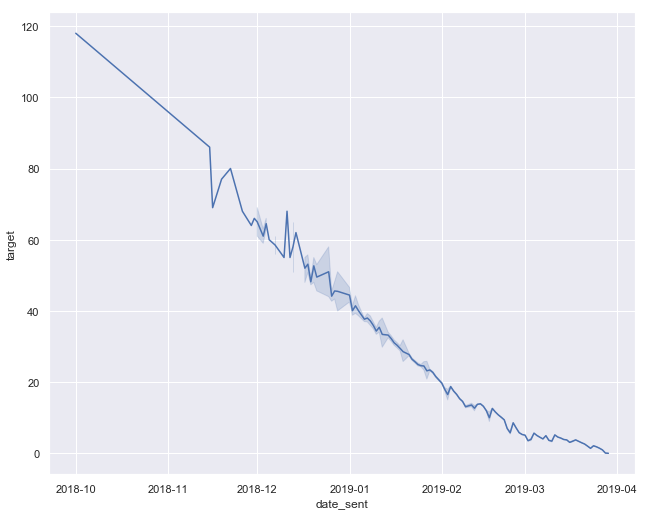

In [287]:
sb.lineplot(x='date_sent', y='target', data=data_sorted_by_date)

**Cantidad de dias habiles que se demoraron los pedidos en ser entregados para una muestra del 1% de los datos**

In [ ]:
n = 10000
sb.lineplot(x='date_sent', y='target', data=data_sorted_by_date.sample(n=n))

**Cantidad de dias habiles que tardo cada servicio en enviar sus pedidos una muestra del 10% de los datos**

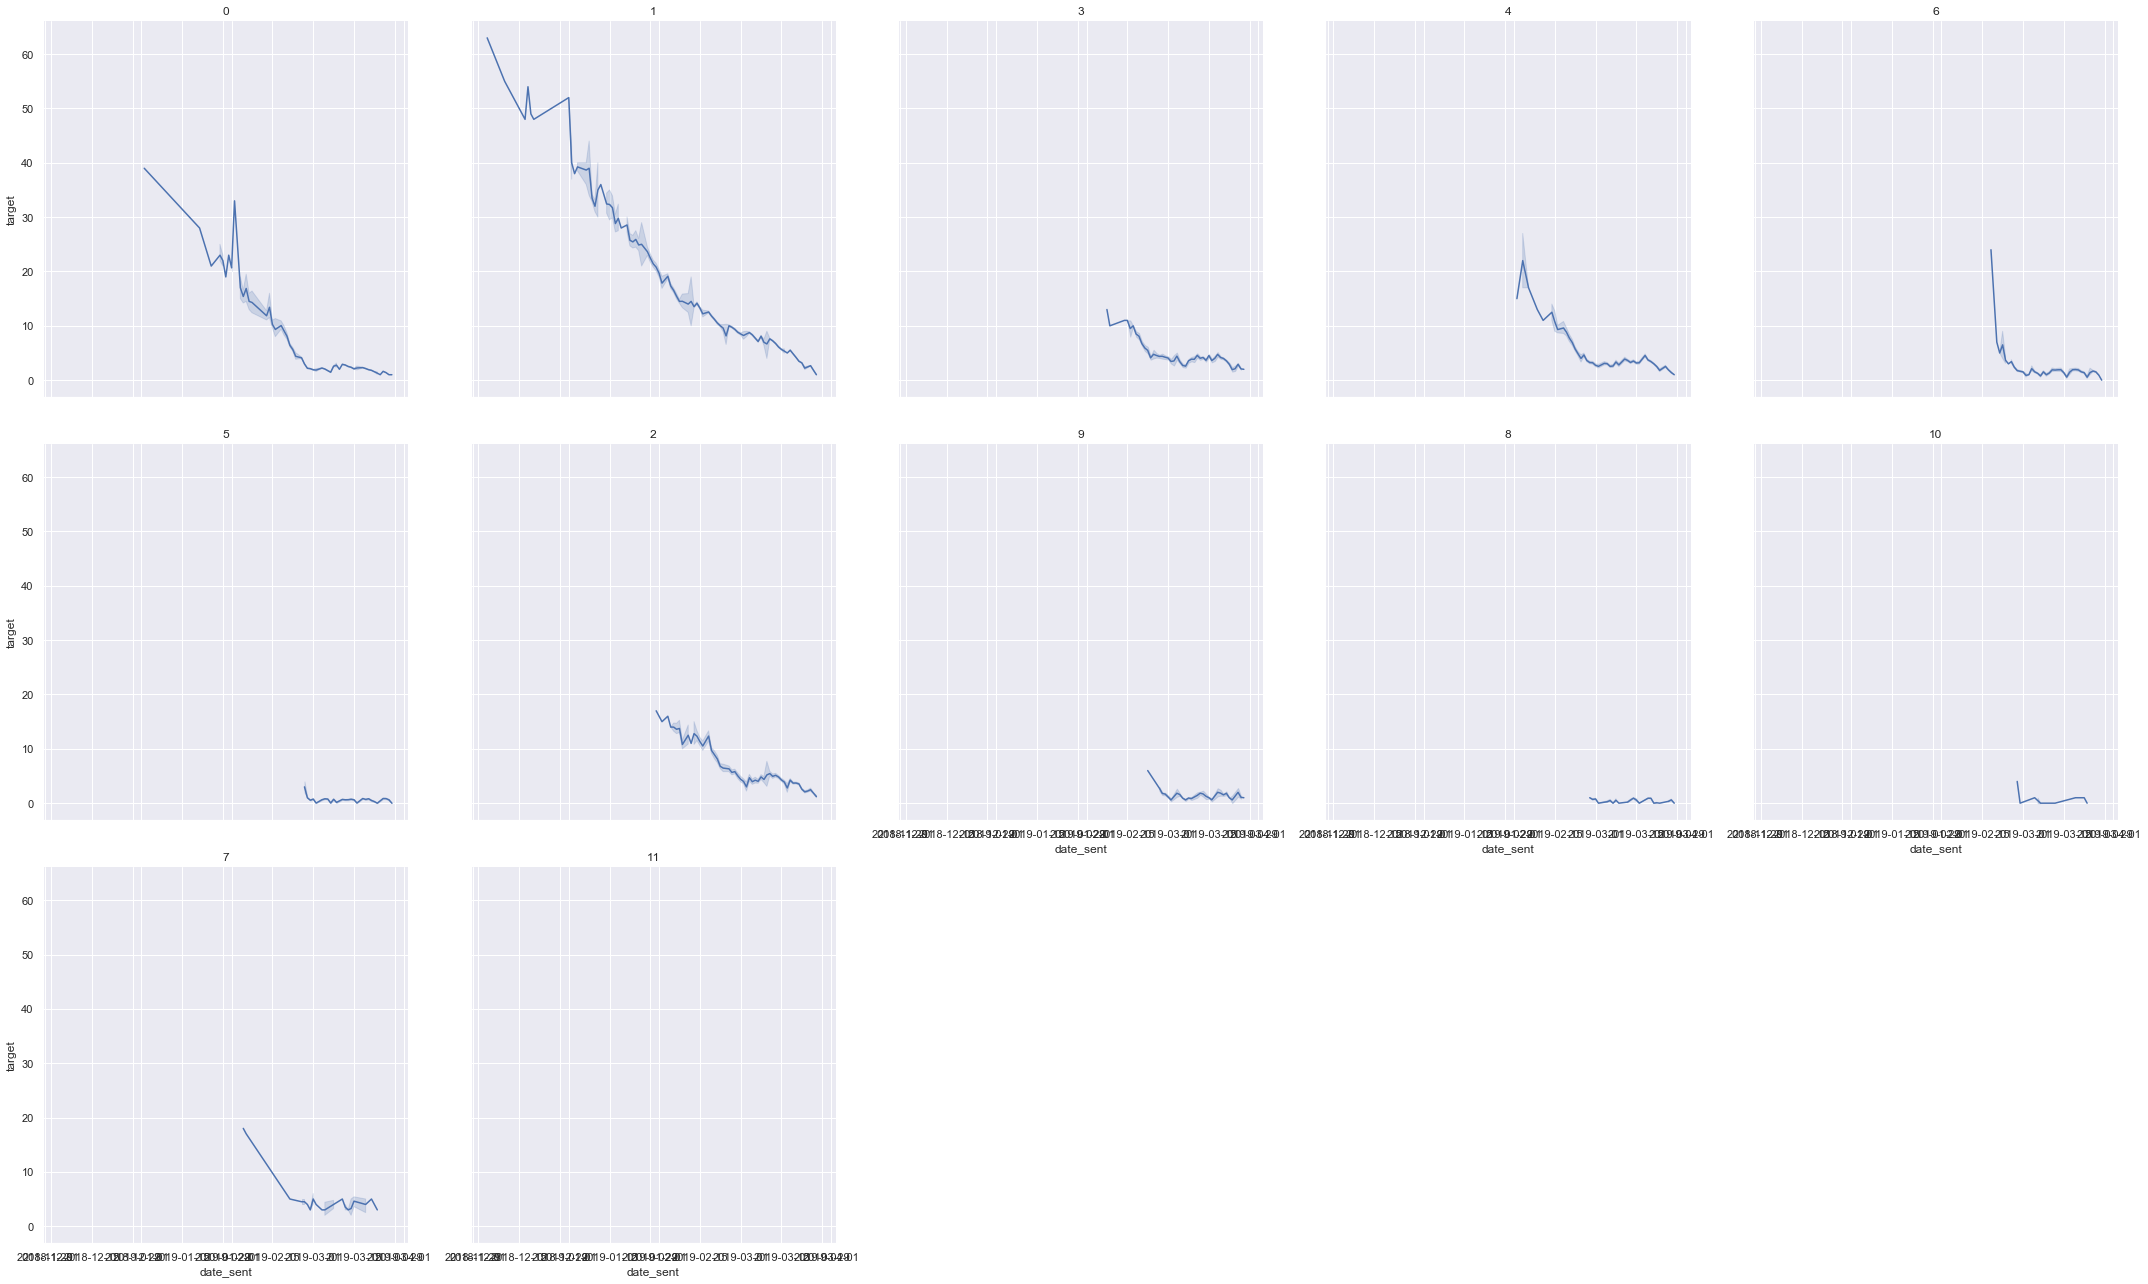

In [282]:
n = 100000
g = sb.FacetGrid(data=data_sorted_by_date.sample(n=n), col='service', col_wrap=5, height=6, col_order=services)
g.map(sb.lineplot, 'date_sent', 'target').set_titles('{col_name}')
plt.show()

**Estadisticos para la variable target**

In [296]:
print(f"Valor minimo: {df['target'].min()}")
print(f"Valor maximo: {df['target'].max()}")
print(f"Media: {df['target'].mean()}")
print(f"Dev std: {df['target'].std()}")
print(f"Mediana: {df['target'].median()}")
      

Valor minimo: 0
Valor maximo: 118
Media: 6.021577
Dev std: 5.157973055157452
Mediana: 4.0


In [297]:
df['target'].describe()

count    1000000.000000
mean           6.021577
std            5.157973
min            0.000000
25%            2.000000
50%            4.000000
75%            9.000000
max          118.000000
Name: target, dtype: float64

**Distribución de la variable target**

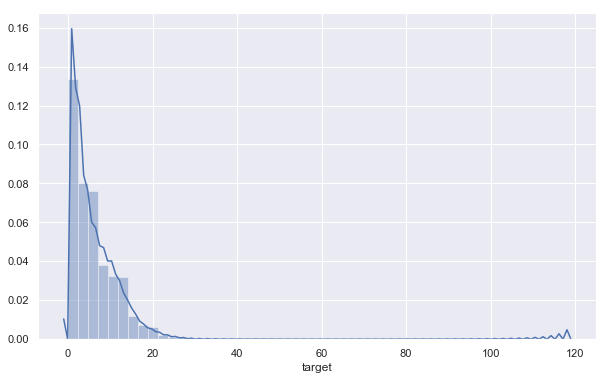

In [298]:
plt.figure(figsize=(10,6))
sb.distplot(df['target'])

In [346]:
from scipy.stats import expon, kstest
kstest(datos, expon(scale=1.0 / df['target'].mean()).cdf)


KstestResult(statistic=0.9675741589743063, pvalue=2.455584656132806e-149)

El calculo del estimador KS indica que se puede rechazar la idea de que el atributo target
distribuye como una distribución exponencial (Dado a un p_valor muy bajo).
O dicho de otra forma, se puede decir que el atributo target no se ajusta a una distribución exponencial

Servicios
- Graficar solo la parte más informativa de la distribución del target para los 4
servicios más representados, con los cuidados correspondientes.
- ¿Existen servicios más rápidos que otros?
- ¿Existen servicios similares entre sí? ¿Alguna idea de porque?
- (Extra) ¿Podrías identificar cuántos correos aparecen en los datos?

Estados
- Graficar solo la parte más informativa de la distribución del target para los 4 estados
más representados, con los cuidados correspondientes.
- ¿Cómo están distribuidos los vendedores geográficamente?
- ¿Cómo es la participación de los servicios dentro y fuera de San Pablo?
- (Extra) ¿Podrías explicar porque estos estados están más representados que los
otros?
- Realizar un mapa de calor utilizando los zipcodes de los vendedores y los
compradores.
- ¿Cual es la relación entre los zipcodes y los estados?

Se espera que utilicen las preguntas como guía de lo que se espera que vean en los datos,
todas las respuestas tienen que estar justificadas con datos o gráficos. Se evaluará la
legibilidad del notebook, el detalle a la hora de responder las preguntas y mostrar la
información solicitada, y además que los gráficos utilizados sean apropiados y correctos. La
información no contemplada en las preguntas que se logre encontrar y presentar
correctamente será valorada.

# Conclusion